In [162]:
%matplotlib inline

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-talk')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

### Загрузим данные 

In [164]:
from scipy import sparse

train = sparse.load_npz("ml-2025-spring-unsupervised/train.npz")
df = pd.DataFrame.sparse.from_spmatrix(train)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048
0,0,0,0,0,0,0,0,0,0,-2.768933,...,-0.701483,0,0,0,0,0,0,9.159356,0,0
1,0,0,0,0,0,0,0,0,0,-3.88886,...,0,0,0,0,0,0,0,4.432927,0,0
2,0,0,1.0,0,0,0.421439,0,0,0,-4.933763,...,0,0,0,0,0,0,0,6.108399,0,0
3,0,0,0,0,0,0,0,0,0,-1.206711,...,0,0,0,0,0,0,0,2.201683,0,0
4,0,0.984401,0,0,0,0.358189,0,0,0,-2.759784,...,0,0,0,0,0,0,0,9.807939,0,0


## 1. K-Means со всеми фичами
Алгоритм будет следующий
* Отнормируем вектор-столбец для каждого признака с помощью `RobustScaler` или `StandardScaler`;
* Используем метод K-средних. Выберем число кластеров с помощью критерия силуэта;
* Ещё оценим число кластеров с помощью метода локтя и соотнесём с критерием силуэта;
* Обучим модель и построим график полученной кластеризации.

In [169]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm.auto import trange
from kneed import KneeLocator

Сразу заметим, что из-за разреженности матрицы X_train, standard_scaler и robust_scaler при нормализации не дадут вычесть мат. ожидание. Поэтому без уменьшения размерности нормализация получается "неполной" – каждый столбец делится только на дисперсию.

In [166]:
standard_scaler = StandardScaler(with_mean=False)
robust_scaler = RobustScaler(with_centering=False)

X_train = df.iloc[:, 1:]
X_train = standard_scaler.fit_transform(X_train)
pd.DataFrame.sparse.from_spmatrix(X_train[:5])

,0,1,2,3,4,5,6,7,8,9,...,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047
0,0,0,0,0,0,0,0,0,-1.241881,0,...,-1.214894,0,0,0,0,0,0,2.772892,0,0
1,0,0,0,0,0,0,0,0,-1.744175,0,...,0,0,0,0,0,0,0,1.342019,0,0
2,0,2.809032,0,0,0.701508,0,0,0,-2.212819,0,...,0,0,0,0,0,0,0,1.849249,0,0
3,0,0,0,0,0,0,0,0,-0.541216,0,...,0,0,0,0,0,0,0,0.666535,0,0
4,3.593012,0,0,0,0.596225,0,0,0,-1.237778,0,...,0,0,0,0,0,0,0,2.969243,0,0


In [175]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_train)
X2

array([[ 0.14005409,  0.71225384],
       [ 1.1511995 ,  2.06838517],
       [ 2.0533713 ,  3.25670443],
       ...,
       [ 0.17342388,  0.32571181],
       [ 0.97202725,  2.37024734],
       [-0.31129769,  2.07478307]])

Выведем силуэт скоры для каждой из моделей K-средних при различных k

In [171]:
for k in trange(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, labels, metric='euclidean')
    print(f"Silhouette score for K={k}: {score:.3f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Silhouette score for K=2: 0.021
Silhouette score for K=3: 0.018
Silhouette score for K=4: -0.004
Silhouette score for K=5: -0.007
Silhouette score for K=6: -0.007
Silhouette score for K=7: -0.008
Silhouette score for K=8: -0.008
Silhouette score for K=9: -0.008


Силуэты примерно одинаково плохи для всех k. Посмотрим на метод локтя

  0%|          | 0/8 [00:00<?, ?it/s]

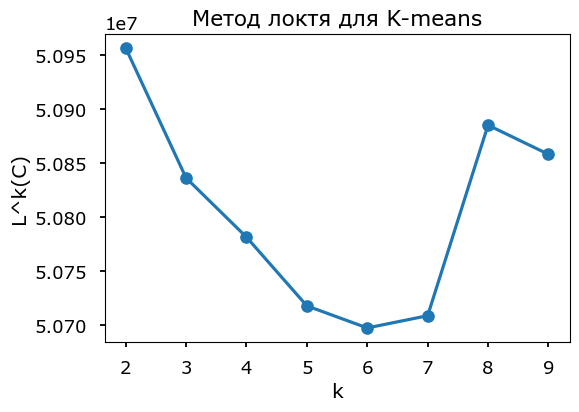

In [173]:
inertias = []
for k in trange(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

k = np.arange(2, 10)
plt.figure(figsize=(6,4))
plt.plot(k, inertias, marker='o')
plt.xticks(k)
plt.xlabel('k')
plt.ylabel('L^k(C)')
plt.title('Метод локтя для K-means')
plt.show()

In [174]:
kneedle = KneeLocator(k, inertias, curve="convex", direction="decreasing")
optimal_k = int(kneedle.knee)
optimal_k

5

То есть датасет разбивается на 5-7 кластеров, и это даже без понижения размерности

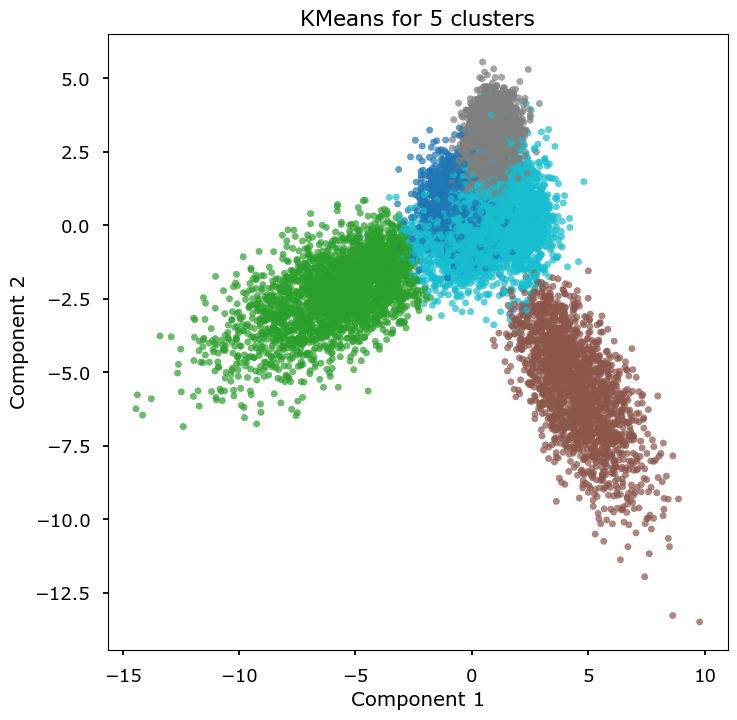

In [177]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_train)

plt.figure(figsize=(8,8))
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
plt.title("KMeans for 5 clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

<b> Полученный ARI для этого решения: 0,14 <b>

## 2. K-Means с понижением размерности
* В этот раз попробуем выкинуть коррелирующие друг с другом фичи;
* Будем использовать `SVD`, т.к. данные разрежены и не центрированы;

Попробуем 2 подхода:
1) Получим число новых признаков с помощью суммарной доли объяснённой дисперсии - график Cumulative;
2) Будем опираться на график с долей объяснённой дисперсии для каждой новой компоненты.

In [178]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

In [181]:
svd = TruncatedSVD(n_components=1830, random_state=42)
X_svd = svd.fit_transform(X_train)

ratio = svd.explained_variance_ratio_
cum = np.cumsum(ratio)
cum[-1]

0.8518714255606694

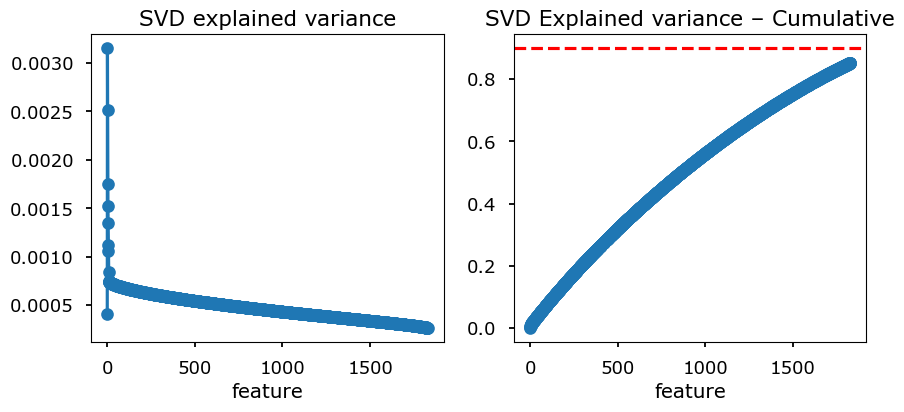

In [182]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(ratio, marker='o')
ax[0].set_title('SVD explained variance'); 
ax[0].set_xlabel('feature')

ax[1].plot(cum, marker='o'); 
ax[1].axhline(0.9, c='r', ls='--')
ax[1].set_title('SVD Explained variance – Cumulative'); 
ax[1].set_xlabel('feature')
plt.show()

* Из 1-ого графика видно, что он равномерно убывает, каждая компонента вносит небольшой вклад, а также имеется достаточно большой хвост, который хочется отбросить;
* Из 2-ого графика видно, что суммарная доля дисперсии растёт медленно. При n = 1830 (МГТУ юху) кривая почти пересечёт красную линию, т.е. суммарная объяснённая дисперсия будет около 90%

Сначала попробуем 1-ый подход – смотрим суммарную диспресию. При n = 1830 размерность всё ещё большая, но все лишние компоненты точно были отброшены. Посмотрим, какое число кластеров даст в этом случае метод локтя.

  0%|          | 0/13 [00:00<?, ?it/s]

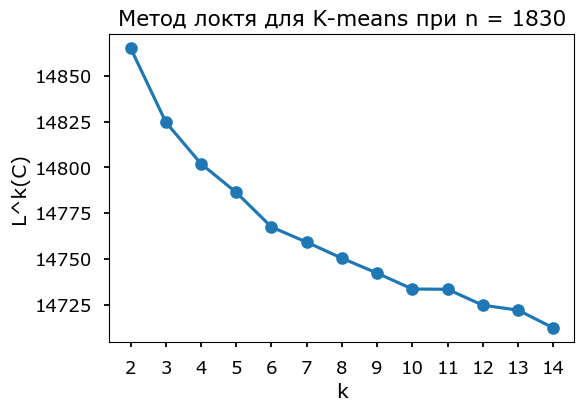

In [183]:
X_train_svd = normalize(X_svd, norm='l2', axis=1)
X2_svd = pca.fit_transform(X_train_svd)

inertias = []
for k in trange(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_svd)
    inertias.append(kmeans.inertia_)

k = np.arange(2, 15)
plt.figure(figsize=(6,4))
plt.plot(k, inertias, marker='o')
plt.xticks(k)
plt.xlabel('k')
plt.ylabel('L^k(C)')
plt.title('Метод локтя для K-means при n = 1830')
plt.show()

In [184]:
kneedle = KneeLocator(k, inertias, curve="convex", direction="decreasing")
optimal_k = int(kneedle.knee)
optimal_k

6

Из графика видно, что k = 6-9 - идеальный вариант. Попробуем k = 6 - точку max излома.

In [187]:
kmeans_svd = KMeans(n_clusters=6, random_state=42)
labels_svd = kmeans_svd.fit_predict(X_train_svd)
score_svd = silhouette_score(X_train_svd, labels_svd, metric='euclidean')
score_svd

0.0011727881964519041

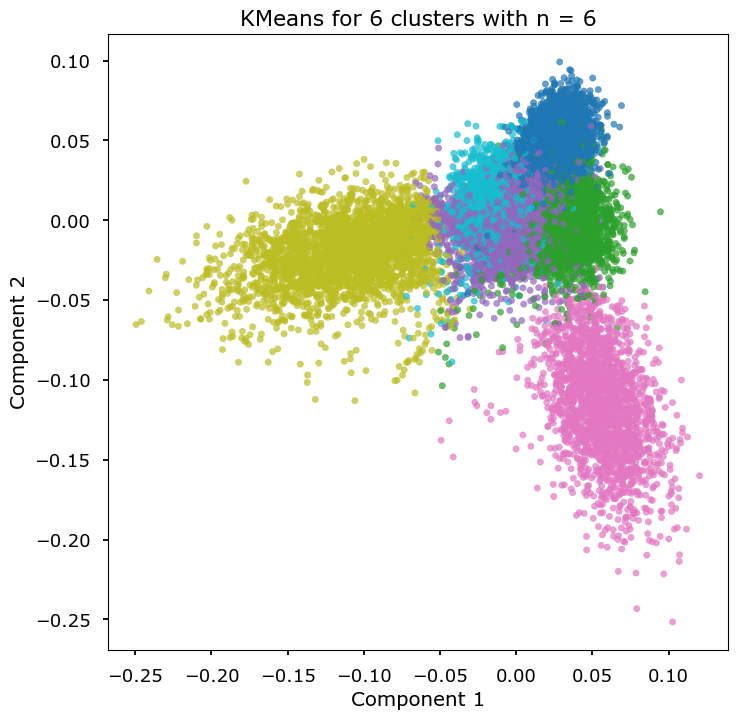

In [188]:
plt.figure(figsize=(8,8))
plt.scatter(X2_svd[:, 0], X2_svd[:, 1], c=labels_svd, cmap='tab10', s=20, alpha=0.7)
plt.title("KMeans for 6 clusters with n = 6")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

<b> Полученный ARI для этого решения: 0,23 <b>

Выбор кол-ва признаков, исходя из суммарной дисперсии, не дал существенных результатов. Теперт попробуем 2-ой подход – оставим компоненты с самой большой дисперсией, а хвост отбросим.

График SVD Explained Variance не даёт должную информацию о том, какой хвост стоит отбросить. Зафиксируем k = 6. И воспользуемся критерием силуэт скора.

In [191]:
shiloutes_svd = []
for n in trange(10, 150):
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_svd = svd.fit_transform(X_train)
    X_svd = normalize(X_svd, norm='l2', axis=1)
    kmeans_svd = KMeans(n_clusters=6, random_state=42)
    labels_svd = kmeans_svd.fit_predict(X_svd)
    score_svd = silhouette_score(X_svd, labels_svd, metric='euclidean')
    shiloutes_svd.append(score_svd)

  0%|          | 0/140 [00:00<?, ?it/s]

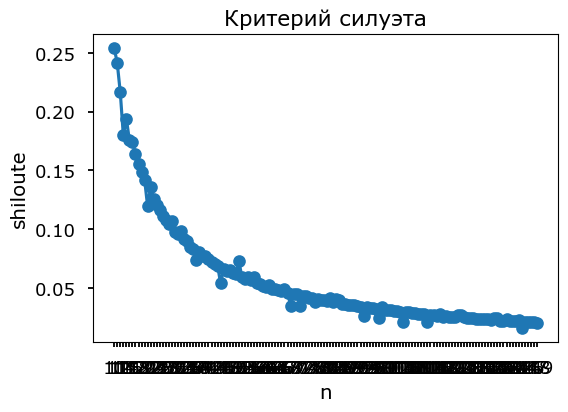

In [193]:
n = np.arange(10, 150)
plt.figure(figsize=(6,4))
plt.plot(n, shiloutes_svd, marker='o')
plt.xticks(n)
plt.xlabel('n')
plt.ylabel('shiloute')
plt.title('Критерий силуэта')
plt.show()

## 3. K-Means с большим понижением размерности и повышение числа кластеров

Из графика видно, что 40 <= n <= 80 дают хорошее соотношение силуэт/кол-во признаков.

И вообще, на этом моменте я вспомнил про проклятие размерности. Алгоритм K-means - метрический, а значит большое кол-во признаков может сделать его неэффективным. Поэтому в дальнейшем я беру признаки по принципу
* Их немного;
* Имеют хороший силуэт скор относительно своих соседей;
* Визуально разбиение на кластеры выглядит хорошо и соотносится с силуэт скором;

Так, например, когда "правая капля" делится на 2 кластера, то силуэт скор падает. Когда же центр дробится, силуэт скор относительно хорош.

In [192]:
svd_41 = TruncatedSVD(n_components=41, random_state=42)
X_41 = svd_41.fit_transform(X_train)
X_41 = normalize(X_41, norm='l2', axis=1)
X2_41 = pca.fit_transform(X_41)

kmeans_41 = KMeans(n_clusters=6, random_state=42)
labels_41 = kmeans_41.fit_predict(X_41)
score_41 = silhouette_score(X_41, labels_41, metric='euclidean')
score_41

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


0.0742369273609067

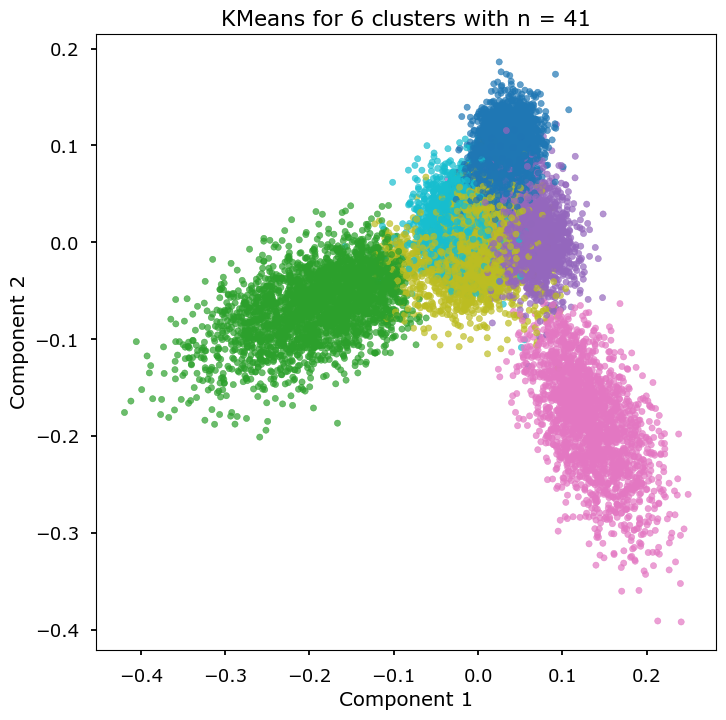

In [194]:
plt.figure(figsize=(8,8))
plt.scatter(X2_41[:, 0], X2_41[:, 1], c=labels_41, cmap='tab10', s=20, alpha=0.7)
plt.title("KMeans for 6 clusters with n = 41")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

<b> Полученный ARI для этого решения: 0,68532 <b>

### Итоговое решение

Я попробовал взять больше кластеров и оставить больше компонент.

In [195]:
svd_68 = TruncatedSVD(n_components=68, random_state=42)
X_68 = svd_68.fit_transform(X_train)
X_68 = normalize(X_68, norm='l2', axis=1)
X2_68 = pca.fit_transform(X_68)

kmeans_68 = KMeans(n_clusters=8, random_state=42)
labels_68 = kmeans_68.fit_predict(X_68)
score_68 = silhouette_score(X_68, labels_68, metric='euclidean')
score_68

0.04282861886718356

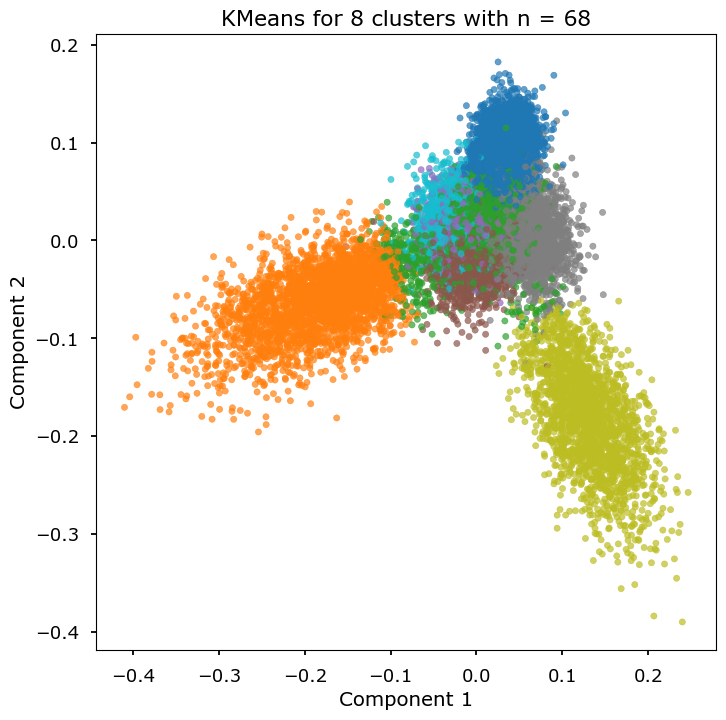

In [196]:
plt.figure(figsize=(8,8))
plt.scatter(X2_68[:, 0], X2_68[:, 1], c=labels_68, cmap='tab10', s=20, alpha=0.7)
plt.title("KMeans for 8 clusters with n = 68")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

<b> Полученный ARI для этого решения: 0,74818 <b>

### Сохранение результатов в submission.csv

In [197]:
submission = pd.DataFrame({
    'ID': df.index,
    'TARGET': labels_68
})

submission.to_csv('submission.csv', index=False)

In [198]:
df_res = pd.read_csv('submission.csv')
df_res.loc[:, 'TARGET'].value_counts()

TARGET
0    4805
2    4674
1    2663
5    2463
6    1938
4    1626
7    1447
3    1384
Name: count, dtype: int64